In [1]:
# conda install jupyter notebook -y
# conda install numpy matplotlib seaborn tqdm -y
# conda install pytorch torchvision torchaudio pytorch-cuda=11.7 -c pytorch -c nvidia

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time

In [3]:
M_t = 40
N_t = 20

M_a = 20
N_a = 3

In [4]:
def x_t(i):
    return i * 0.5

def y_t(j):
    return j * 0.5

def x_a(i):
    return i * 10 - 5

def y_a(j):
    return j * 10 - 15

In [5]:
def I_s(x, y, x_o, y_o, I_0, sigma_I):
    return I_0 * np.exp( - ((x - x_o)**2 + (y - y_o)**2) / (2 * (sigma_I**2)))

def I_t(x, y, x_o=10, y_o=5, I_0=2.5, sigma_I=0.3):
    return I_s(x, y, x_o, y_o, I_0, sigma_I)

def I_a(x, y, x_o=100, y_o=15, I_0=3.6, sigma_I=0.3):
    return I_s(x, y, x_o, y_o, I_0, sigma_I)

In [6]:
def phi_s(x, y, x_i, y_j, phi_0, sigma_phi):
    return phi_0 * np.exp( - ((x - x_i)**2 + (y - y_j)**2) / (2 * (sigma_phi**2)))

def phi_t(x, y, x_i, y_j, phi_0=1, sigma_phi=1):
    return phi_s(x, y, x_i, y_j, phi_0, sigma_phi)

def phi_a(x, y, x_i, y_j, phi_0=1, sigma_phi=10):
    return phi_s(x, y, x_i, y_j, phi_0, sigma_phi)

In [7]:
def tactile(M=40, N=20, d=0.5, delta_x_l=0.2, delta_y_n=0.2):
    area_t = np.zeros((N, M))
    
    for i in range(M):
        for j in range(N):
            sum_phi_t = 0
            
            for x_l in np.arange(delta_x_l, 20, delta_x_l):
                    for y_n in np.arange(delta_y_n, 10, delta_y_n):
                        x_i = d * (i + 1) 
                        y_j = d * (j + 1)
                        
                        sum_phi_t += I_t(x_l, y_n) * phi_t(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
                
                        area_t[j][i] = sum_phi_t
            
    return area_t

def auditory(M=20, N=3, d=10, delta_x_l=0.2, delta_y_n=0.2):
    area_a = np.zeros((N, M))
    
    for i in range(M):
        for j in range(N):
            sum_phi_a = 0
    
            for x_l in np.arange(delta_x_l, 200, delta_x_l):
                for y_n in np.arange(delta_y_n, 30, delta_y_n):
                    x_i = d * (i + 1) - 5
                    y_j = d * (j + 1) - 15
                    
                    sum_phi_a += I_a(x_l, y_n) * phi_a(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
            
            area_a[j][i] = sum_phi_a
            
    return area_a

In [8]:
phi_t_net = tactile()
phi_a_net = auditory()

<AxesSubplot: >

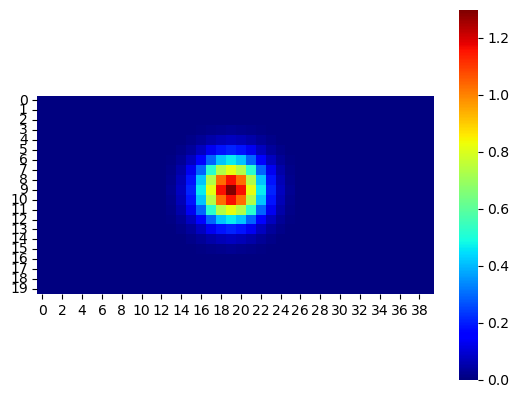

In [9]:
sns.heatmap(phi_t_net, square=True, cmap="jet")

<AxesSubplot: >

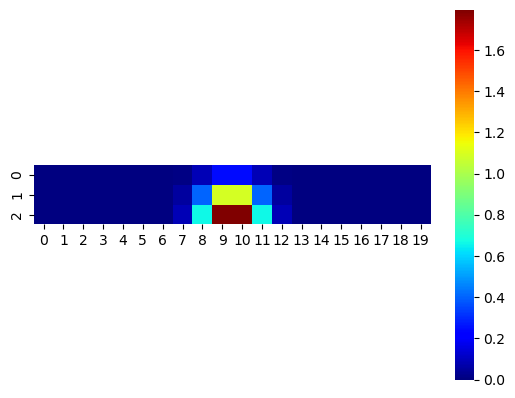

In [10]:
sns.heatmap(phi_a_net, square=True, cmap="jet")

In [11]:
def L_s(D_x, D_y, L_ex, sigma_ex, L_in, sigma_in):
    ve = L_ex * np.exp( - (D_x**2 + D_y**2) / (2 * (sigma_ex**2)))
    vi = L_in * np.exp( - (D_x**2 + D_y**2) / (2 * (sigma_in**2)))
    
    return ve - vi

def L_t(D_x, D_y, L_ex_t=0.15, sigma_ex_t=1, L_in_t=0.05, sigma_in_t=1):
    return L_s(D_x, D_y, L_ex_t, sigma_ex_t, L_in_t, sigma_in_t)

def L_a(D_x, D_y, L_ex_a=0.15, sigma_ex_a=20, L_in_a=0.05, sigma_in_a=80):
    return L_s(D_x, D_y, L_ex_a, sigma_ex_a, L_in_a, sigma_in_a)

In [12]:
def get_matrix_for_ij_t(i_o, j_o, M, N):
    conn_matrix = np.zeros((N, M))
    
    for i in range(M):
        for j in range(N):
            if i + 1 == i_o and j + 1 == j_o:
                conn_matrix[j][i] = 0
            else:
                D_x = x_t(i + 1) - x_t(i_o)
                D_y = y_t(j + 1) - y_t(j_o)
                
                conn_matrix[j][i] = L_t(D_x, D_y)
    
    return conn_matrix

def conn_t(M=40, N=20):
    net = {}

    for i in range(M):
        for j in (range(N)):
            net[(i + 1, j + 1)] = get_matrix_for_ij_t(i + 1, j + 1, M, N)
            
    return net

In [13]:
all_conn_t = conn_t()

<AxesSubplot: >

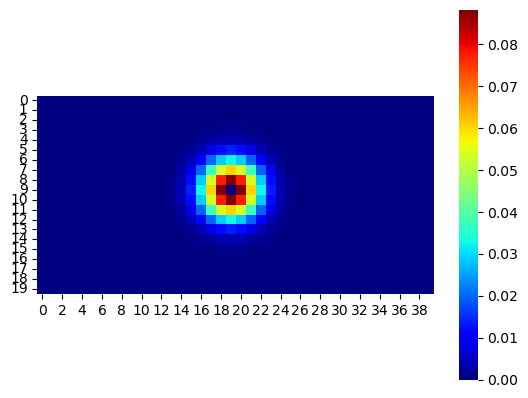

In [14]:
matrix_t = all_conn_t[(20, 10)]

sns.heatmap(matrix_t, square=True, cmap="jet")

In [15]:
def conn_a(M=20, N=3):
    net = {}

    for i in range(M):
        for j in (range(N)):
            net[(i + 1, j + 1)] = get_matrix_for_ij_a(i + 1, j + 1, M, N)
            
    return net
            
def get_matrix_for_ij_a(i_o, j_o, M, N):
    conn_matrix = np.zeros((N, M))
    
    for i in range(M):
        for j in range(N):
            if i + 1 == i_o and j + 1 == j_o:
                conn_matrix[j][i] = 0
            else:
                D_x = x_a(i + 1) - x_a(i_o)
                D_y = y_a(j + 1) - y_a(j_o)
                
                conn_matrix[j][i] = L_a(D_x, D_y)
    
    return conn_matrix

In [16]:
all_conn_a = conn_a()

<AxesSubplot: >

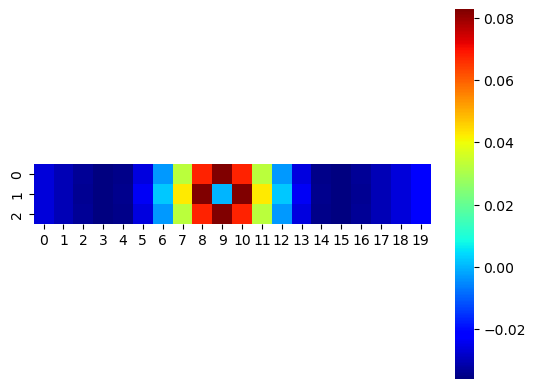

In [17]:
matrix_a = all_conn_a[(10, 2)]

sns.heatmap(matrix_a, square=True, cmap="jet")

In [18]:
W0_t = 6.5
B0_t = 2.5

In [19]:
def W_t():
    return W0_t

def B_t():
    return B0_t

In [20]:
W0_a = 6.5
B0_a = 2.5

In [21]:
k1 = 15
k2 = 800
alpha = 0.9
Lim = 65

In [22]:
def W_a(D):
    return alpha * W0_a * np.exp(-( D / k1 )) + (1 - alpha) * W0_a * np.exp(-( D / k2 ))

def B_a(D):
    return alpha * B0_a * np.exp(-( D / k1 )) + (1 - alpha) * B0_a * np.exp(-( D / k2 ))

In [23]:
def D_a(i, j):
    if x_a(i) < Lim:
        return 0
    else:
        return x_a(i) - Lim

In [24]:
def Forward_a(M=20, N=3):
    conn_matrix = np.zeros((N, M))
    
    for i in range(M):
        for j in range(N):
            conn_matrix[j][i] = W_a(D_a(i, j))
    
    return conn_matrix

def Backward_a(M=20, N=3):
    conn_matrix = np.zeros((N, M))
    
    for i in range(M):
        for j in range(N):
            conn_matrix[j][i] = B_a(D_a(i, j))
    
    return conn_matrix

<AxesSubplot: >

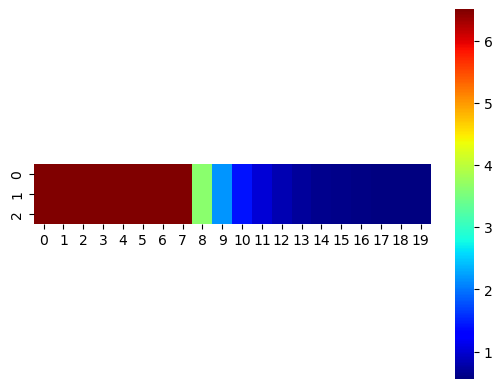

In [25]:
W_a_matrix = Forward_a()

sns.heatmap(W_a_matrix, square=True, cmap="jet")

<AxesSubplot: >

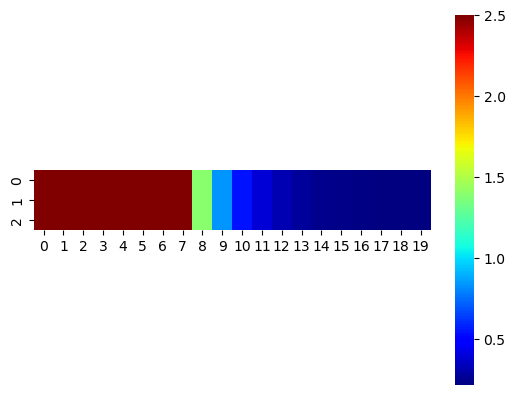

In [26]:
B_a_matrix = Backward_a()

sns.heatmap(B_a_matrix, square=True, cmap="jet")

In [27]:
fmin_t = -0.12
fmax_t = 1
qc_t = 19.43
r_t = 0.34

In [28]:
fmin_a = -0.12
fmax_a = 1
qc_a = 19.43
r_a = 0.34

In [29]:
fmin_m = 0
fmax_m = 1
qc_m = 12
r_m = 0.6

In [30]:
tau = 20

In [31]:
def G_m(q_m):
    factor = np.exp((q_m - qc_m) * r_m)
    return (fmin_m + fmax_m * factor) / (1 + factor)
    
def z_m(q_m):
    F_val = G_m(q_m)
    if F_val >= 0:
        return F_val
    else:
        return 0.0

In [32]:
def q_t(area, i, j):
    return area[j][i]

def F_t(area, i, j):
    factor = np.exp((q_t(area, i, j) - qc_t) * r_t)
    return (fmin_t + fmax_t * factor) / (1 + factor)
    
def z_t(area, i, j):
    F_val = F_t(area, i, j)
    if F_val >= 0:
        return F_val
    else:
        return 0.0

In [33]:
def I2_t(area, i, j):
    sum_val = 0.0
    tmp_conn = all_conn_t[(i + 1, j + 1)]
    for h in range(tmp_conn.shape[1]):
        for k in range(tmp_conn.shape[0]):
            sum_val += tmp_conn[k][h] * z_t(area, i, j)
    return sum_val

def phi2_t(i, j, d=0.5, delta_x_l=0.2, delta_y_n=0.2):
    sum_phi_t = 0.0
    
    for x_l in np.arange(delta_x_l, 20, delta_x_l):
        for y_n in np.arange(delta_y_n, 10, delta_y_n):
            x_i = x_t(i + 1)
            y_j = y_t(j + 1)
            
            sum_phi_t += I_t(x_l, y_n) * phi_t(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
            
    return sum_phi_t

def B2_t(q_m):
    return B_t() + z_m(q_m)

<AxesSubplot: >

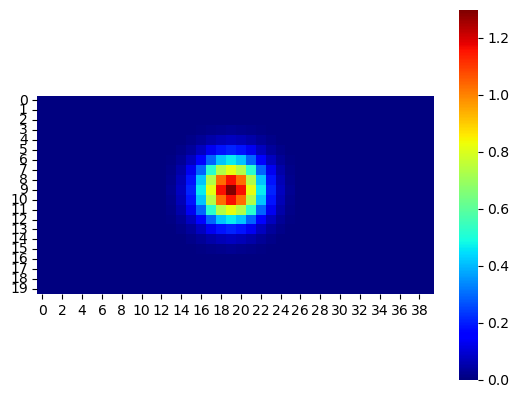

In [34]:
phi_t_net = np.zeros((N_t, M_t))

for i in range(M_t):
    for j in range(N_t):
        phi_t_net[j][i] = phi2_t(i, j)
        
sns.heatmap(phi_t_net, square=True, cmap="jet")

In [35]:
def u_t(area, i, j, q_m):
    return phi_t_net[j][i] + I2_t(area, i, j) + B2_t(q_m)

def fire_t(area, q_m, d_t=0.4):
    next_states = np.zeros((N_t, M_t))
    for i in range(M_t):
        for j in range(N_t):
            d_q = -q_t(area, i, j) + u_t(area, i, j, q_m)
            next_states[j][i] = area[j][i] + 1/tau * d_t * d_q
    return next_states

In [36]:
def q_a(area, i, j):
    return area[j][i]

def F_a(area, i, j):
    factor = np.exp((q_a(area, i, j) - qc_a) * r_a)
    return (fmin_a + fmax_a * factor) / (1 + factor)
    
def z_a(area, i, j):
    F_val = F_t(area, i, j)
    if F_val >= 0:
        return F_val
    else:
        return 0.0

In [37]:
def I2_a(area, i, j):
    sum_val = 0.0
    tmp_conn = all_conn_a[(i + 1, j + 1)]
    for h in range(tmp_conn.shape[1]):
        for k in range(tmp_conn.shape[0]):
            sum_val += tmp_conn[k][h] * z_a(area, i, j)
    return sum_val

def phi2_a(i, j, d=10, delta_x_l=0.2, delta_y_n=0.2):
    sum_phi_a = 0.0
    
    for x_l in np.arange(delta_x_l, 200, delta_x_l):
        for y_n in np.arange(delta_y_n, 30, delta_y_n):
            x_i = x_a(i + 1)
            y_j = y_a(j + 1)
                    
            sum_phi_a += I_a(x_l, y_n) * phi_a(x_l, y_n, x_i, y_j) * delta_x_l * delta_y_n
            
    return sum_phi_a

def B2_a(i, j, q_m):
    return B_a_matrix[j][i] + z_m(q_m)

<AxesSubplot: >

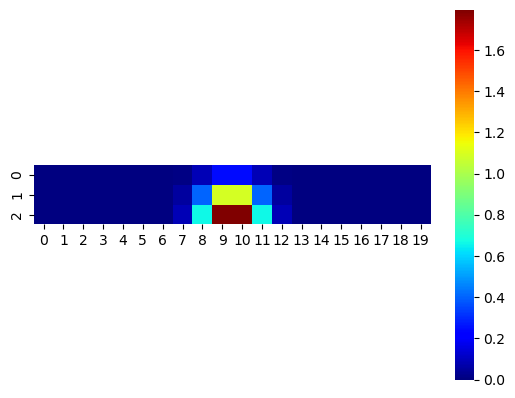

In [38]:
phi_a_net = np.zeros((N_a, M_a))

for i in range(M_a):
    for j in range(N_a):
        phi_a_net[j][i] = phi2_a(i, j)
        
sns.heatmap(phi_a_net, square=True, cmap="jet")

In [39]:
def u_a(area, i, j, q_m):
    return phi_a_net[j][i] + I2_a(area, i, j) + B2_a(i, j, q_m)

def fire_a(area, q_m, d_t=0.4):
    next_states = np.zeros((N_a, M_a))
    for i in range(M_a):
        for j in range(N_a):
            d_q = -q_a(area, i, j) + u_a(area, i, j, q_m)
            next_states[j][i] = area[j][i] + 1/tau * d_t * d_q
    return next_states

In [40]:
def u_m(area_t, area_a):
    s = time.time()
    
    sum_t = 0
    for i in range(M_t):
        for j in range(N_t):
            sum_t += W_t() * z_t(area_t, i, j)
            
    sum_a = 0
    for i in range(M_a):
        for j in range(N_a):
            sum_a += W_a_matrix[j][i] * z_a(area_a, i, j)
    
    return sum_t + sum_a

In [41]:
q_m = 0.0

area_t = np.zeros((N_t, M_t))
area_a = np.zeros((N_a, M_a))

d_t = 0.4
total_time = 200

for i in tqdm(range(int(total_time/d_t))):
    area_t = fire_t(area_t, q_m)
    area_a = fire_a(area_a, q_m)
    
    d_qm = -q_m + u_m(area_t, area_a)
    q_m = q_m + 1/tau * d_t * d_qm

  0%|          | 0/500 [00:00<?, ?it/s]

<AxesSubplot: >

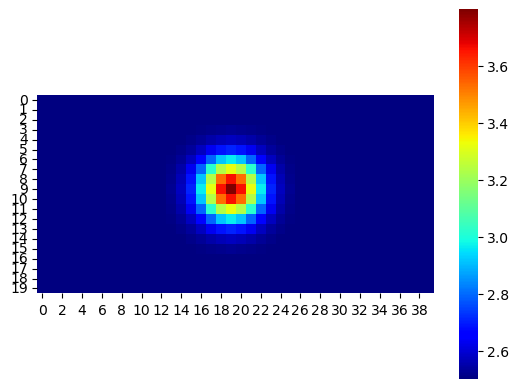

In [42]:
sns.heatmap(area_t, square=True, cmap="jet")

<AxesSubplot: >

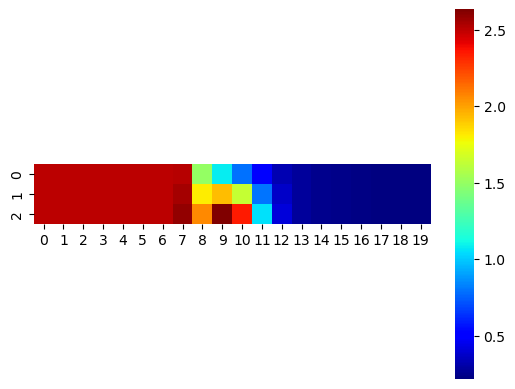

In [43]:
sns.heatmap(area_a, square=True, cmap="jet")